# AQI Data Acquisition

The goal of this notebook is to help with the overall wildland fire analysis for Indianapolis, Indiana, by loading the Air Quality Index (AQI) data. We use data from the US EPA (Environmental Protection Agency) [Air Quality System (AQS) API](https://aqs.epa.gov/aqsweb/documents/data_api.html). 

The Air Quality Index (AQI) is a scale used to communicate how polluted the air is on a given day, with a rating ranging from 0 (clean air) to 500 (highly hazardous air), where a reading between 0-50 is considered healthy air quality.

FIPS related information for Indianapolis:\
IN|18|097|00450371|Marion County|H6|C

## License

A significant portion of the code in this notebook was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative Commons CC-BY license. Revision 1.2 - August 16, 2024.

Modifications to this code were made by Himanshu Naidu on October 26, 2024.

## Setting up the Environment

In [20]:
# 
#    These are standard python modules
#
#import json, time, urllib.parse
import json, time
#
#    The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests

In [21]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [22]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#

In [23]:
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

## Making a Sign-up Request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.

In [24]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [7]:
# Run only once
# response = request_signup(os.getenv("EMAIL"))
# print(json.dumps(response,indent=4))

A response to the signup request might look something like this.


    Requesting SIGNUP ...
    {
        "Header": [
            {
                "status": "Success",
                "request_time": "2023-08-07T17:03:27-04:00",
                "url": "https://aqs.epa.gov/data/api/signup?email=dwmc@uw.edu"
            }
        ],
        "Data": [
            "You should receive a registration confirmation email with a link for confirming your email shortly."
        ]
    }



Note: The code below relies on a third-party package called dotenv to get the required information for accessing the API.

In [25]:
USERNAME = os.getenv("AQS_USERNAME")
APIKEY = os.getenv("AQS_KEY")

## Making a List Request

Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [26]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [ ]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


We're interested in getting to something that might be the Air Quality Index (AQI). You see this reported on the news - often around smog values, but also when there is smoke in the sky. The AQI is a complex measure of different gasses and of the particles in the air (dust, dirt, ash ...).

From the list produced by our 'list/Classes' request above, it looks like there is a class of sensors called "AQI POLLUTANTS". Let's try to get a list of those specific sensors and see what we can get from those.

In [27]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [ ]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor.

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [29]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Now that we know what sensors we want information about, we can search for sensors close to Indianapolis, Indiana.

In [30]:
# IN|18|097|00450371|Marion County|H6|C
CITY_LOCATIONS = { 
    'indianapolis' : {
        'city'   : 'Indianapolis',
        'county' : 'Marion',
        'state'  : 'Indiana',
        'fips'   : '18097',
        'latlon' : [39.7684, -86.1580]
    }
}

In [ ]:
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['indianapolis']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['indianapolis']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.

Indianapolis seems to have several monitoring stations, and thus, it will be possible to proceed with the analysis.

## Making the Daily Summary Request

In [31]:
# IMPORTS
import pandas as pd
from tqdm import tqdm

In [32]:
# CONSTANTS

# We are interested in getting data for the last 60 years
START_YEAR = 1964
END_YEAR = 2024

# We are interested in getting data for the days that belong to the fire season.
START_MMDD = "0501"
END_MMDD = "1031"

# Save paths for the extracted AQI data
GASEOUS_AQI_PATH = "intermediate/gaseous_aqi.csv"
PARTICULATE_AQI_PATH = "intermediate/particulate_aqi.csv"

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [33]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [34]:
def get_AQI_data_from_response(json_response):
    """
    Given a response from the AQS API, this function will extract the relevant AQI data and return it in a more usable format.
    """
    if json_response["Header"][0]['status'] == "Success":
        return json_response['Data']
    elif json_response["Header"][0]['status'].startswith("No data "):
        # print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
        pass
    else:
        print("Unexpected response")
        print(json.dumps(json_response,indent=4))
    return None

In [19]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['indianapolis']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['indianapolis']['fips'][2:]

gaseous_aqi_list = []
particulate_aqi_list = []

for year in tqdm(range(START_YEAR, END_YEAR+1), desc="Fetching AQI data"):
    begin_date = f"{year}{START_MMDD}"
    end_date = f"{year}{END_MMDD}"

    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    gaseous_aqi_data = get_AQI_data_from_response(gaseous_aqi)

    if gaseous_aqi_data: gaseous_aqi_list.extend(gaseous_aqi_data)
    else: print(f"No gaseous AQI data for {year}")

    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    particulate_aqi_data = get_AQI_data_from_response(particulate_aqi)

    if particulate_aqi_data: particulate_aqi_list.extend(particulate_aqi_data)
    else: print(f"No particulate AQI data for {year}")

Fetching AQI data:   2%|▏         | 1/61 [00:00<00:21,  2.77it/s]

No particulate AQI data for 1964


Fetching AQI data:   3%|▎         | 2/61 [00:00<00:21,  2.78it/s]

No particulate AQI data for 1965


Fetching AQI data:   5%|▍         | 3/61 [00:01<00:21,  2.75it/s]

No particulate AQI data for 1966


Fetching AQI data:   7%|▋         | 4/61 [00:01<00:20,  2.76it/s]

No particulate AQI data for 1967


Fetching AQI data:   8%|▊         | 5/61 [00:01<00:20,  2.73it/s]

No particulate AQI data for 1968


Fetching AQI data:  10%|▉         | 6/61 [00:02<00:20,  2.65it/s]

No particulate AQI data for 1969


Fetching AQI data:  11%|█▏        | 7/61 [00:02<00:21,  2.55it/s]

No particulate AQI data for 1970


Fetching AQI data:  13%|█▎        | 8/61 [00:03<00:22,  2.34it/s]

No particulate AQI data for 1971


Fetching AQI data:  15%|█▍        | 9/61 [00:04<00:30,  1.68it/s]

No particulate AQI data for 1972


Fetching AQI data:  16%|█▋        | 10/61 [00:04<00:33,  1.54it/s]

No particulate AQI data for 1973


Fetching AQI data:  18%|█▊        | 11/61 [00:08<01:14,  1.49s/it]

No particulate AQI data for 1974


Fetching AQI data:  20%|█▉        | 12/61 [00:09<01:10,  1.44s/it]

No particulate AQI data for 1975


Fetching AQI data:  21%|██▏       | 13/61 [00:12<01:28,  1.84s/it]

No particulate AQI data for 1976


Fetching AQI data:  23%|██▎       | 14/61 [00:16<01:56,  2.47s/it]

No particulate AQI data for 1977


Fetching AQI data:  25%|██▍       | 15/61 [00:18<01:51,  2.42s/it]

No particulate AQI data for 1978


Fetching AQI data:  26%|██▌       | 16/61 [00:21<01:53,  2.51s/it]

No particulate AQI data for 1979


Fetching AQI data:  28%|██▊       | 17/61 [00:25<02:17,  3.12s/it]

No particulate AQI data for 1980


Fetching AQI data:  30%|██▉       | 18/61 [00:28<02:12,  3.08s/it]

No particulate AQI data for 1981


Fetching AQI data:  31%|███       | 19/61 [00:33<02:30,  3.58s/it]

No particulate AQI data for 1982


Fetching AQI data: 100%|██████████| 61/61 [03:51<00:00,  3.80s/it]


As the logs suggest, the Particulate AQI data only started getting collected from 1983, while Gaseous AQI has been collected since before the last 60 years.

In [20]:
gaseous_aqi_df = pd.DataFrame.from_records(gaseous_aqi_list)
gaseous_aqi_df.to_csv(GASEOUS_AQI_PATH, index=False)

particulate_aqi_df = pd.DataFrame.from_records(particulate_aqi_list)
particulate_aqi_df.to_csv(PARTICULATE_AQI_PATH, index=False)

In [21]:
## In the future, we can load the data from the CSV files for analysis
gaseous_aqi_df = pd.read_csv(GASEOUS_AQI_PATH)
particulate_aqi_df = pd.read_csv(PARTICULATE_AQI_PATH)

/tmp/ipykernel_389899/7742455.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  gaseous_aqi_df = pd.read_csv(GASEOUS_AQI_PATH)


In [22]:
gaseous_aqi_df.shape, particulate_aqi_df.shape

((399854, 32), (213783, 32))

## AQI Data Exploratory Data Analysis

In [54]:
# IMPORTS
import matplotlib.pyplot as plt
import geopandas as gpd

from utils import plot_gdf

In [23]:
# Get rows with non-null AQI
gaseous_aqi_df = gaseous_aqi_df[gaseous_aqi_df['aqi'].notnull()]
particulate_aqi_df = particulate_aqi_df[particulate_aqi_df['aqi'].notnull()]

In [24]:
gaseous_aqi_df.shape, particulate_aqi_df.shape

((243883, 32), (198324, 32))

As one can notice, Indianapolis has access to a rich dataset of AQI data.

In [35]:
# Get only the relevant columns
# for col in gaseous_aqi_df.columns:
#     print(f"\"{col}\",")

RELEVANT_COLUMNS = [
    # "state_code",
    # "county_code",
    "site_number", # ?
    "parameter_code", # 5-digit AQS parameter code
    "poc", # POCs are used when there are multiple devices measuring the same pollutant at a site.
    "latitude",
    "longitude",
    # "datum", # Always WGS84
    "parameter",
    # "sample_duration_code", # redundant and doesn't convey as much as sample_duration
    "sample_duration",
    # "pollutant_standard", # redundant with parameter and sample_duration
    "date_local",
    "units_of_measure",
    # "event_type", # No Events 
    # "observation_count", # Deemed not relevant after online research
    # "observation_percent", # Deemed not relevant after online research
    # "validity_indicator",
    # "arithmetic_mean", # We will be using AQI directly
    # "first_max_value", # We will be using AQI directly
    # "first_max_hour", # We will be using AQI directly
    "aqi",
    # "method_code", # Method will not be used
    # "method", # Method will not be used
    # "local_site_name",
    # "site_address",
    # "state",
    # "county",
    # "city",
    # "cbsa_code",
    # "cbsa",
    # "date_of_last_change",
]

In [26]:
gaseous_aqi_subset_df = gaseous_aqi_df[RELEVANT_COLUMNS]
particulate_aqi_subset_df = particulate_aqi_df[RELEVANT_COLUMNS]

In [52]:
# Concat the two dataframes
aqi_subset_df = pd.concat([gaseous_aqi_subset_df, particulate_aqi_subset_df], ignore_index=True)

In [58]:
# There are 51 sites recording AQI data for Indianapolis
aqi_sites_df = aqi_subset_df[['site_number', 'latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Use location data to create a GeoDataFrame
aqi_sites_gdf = gpd.GeoDataFrame(aqi_sites_df, geometry=gpd.points_from_xy(aqi_sites_df.longitude, aqi_sites_df.latitude))
aqi_sites_gdf.crs = "EPSG:4326"

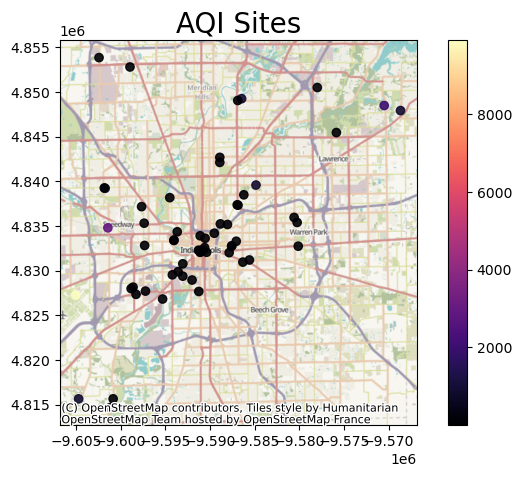

In [59]:
# As mentioned, EPSG:4326 can be used for mapping, but for distance calculations, we will use EPSG:5070
fix, ax = plot_gdf(aqi_sites_gdf, 'site_number', cmap='magma', title='AQI Sites', 
    figsize=(8, 5))
plt.show()

As we can see, these sites are all over Indianapolis. While some are closer to the city center, we currently have no literature details on how to prioritize sites, thus for now, we will be giving them all equal priority. 

In [27]:
# Same site can have multiple monitors for the same pollutant at the same day
particulate_aqi_subset_df[(particulate_aqi_subset_df['site_number']==43) 
                          & (particulate_aqi_subset_df['parameter_code']==81102)
                          & (particulate_aqi_subset_df['date_local']=='2021-07-03')]\
                          [['site_number', 'parameter_code', 'date_local', 'poc']].drop_duplicates()

,site_number,parameter_code,date_local,poc
172079,43,81102,2021-07-03,1
172106,43,81102,2021-07-03,2


In [51]:
# Same site's monitor may also report AQI for a parameter multiple times in a day.
# However, these seem to be returning the same value.
aqi_daily_poc_counts = \
    aqi_subset_df.groupby(by=['site_number', 'parameter_code', 'date_local', 'poc']).size()
aqi_daily_poc_counts = aqi_daily_poc_counts[aqi_daily_poc_counts>1]
# aqi_subset_df[(aqi_subset_df['site_number']==42) 
#                           & (aqi_subset_df['parameter_code']==88101)
#                           & (aqi_subset_df['date_local']=='1999-09-18')
#                           & (aqi_subset_df['poc']==1)]
violation_count = 0
for index in tqdm(iterable=aqi_daily_poc_counts.index):
    aqi_daily_variance = aqi_subset_df[(aqi_subset_df['site_number']==index[0]) 
                          & (aqi_subset_df['parameter_code']==index[1])
                          & (aqi_subset_df['date_local']==index[2])
                          & (aqi_subset_df['poc']==index[3])]['aqi'].var()
    if aqi_daily_variance > 0: 
        print(f"The monitor reports different aqi values within the same day with variance: {aqi_daily_variance}")
        violation_count += 1
    if violation_count > 100:
        break

  0%|          | 0/21516 [00:00<?, ?it/s]

100%|██████████| 21516/21516 [03:07<00:00, 114.49it/s]


The lack of logs above means that no varying values were reported by the same monitor for a parameter, within the same day.

In [60]:
aqi_subset_df.head(5)

,site_number,parameter_code,poc,latitude,longitude,parameter,sample_duration,date_local,units_of_measure,aqi
0,80,42101,1,39.767813,-86.158024,Carbon monoxide,8-HR RUN AVG END HOUR,1971-10-01,Parts per million,195.0
1,80,42101,1,39.767813,-86.158024,Carbon monoxide,8-HR RUN AVG END HOUR,1971-10-02,Parts per million,216.0
2,80,42101,1,39.767813,-86.158024,Carbon monoxide,8-HR RUN AVG END HOUR,1971-10-03,Parts per million,115.0
3,80,42101,1,39.767813,-86.158024,Carbon monoxide,8-HR RUN AVG END HOUR,1971-10-04,Parts per million,34.0
4,80,42101,1,39.767813,-86.158024,Carbon monoxide,8-HR RUN AVG END HOUR,1971-10-05,Parts per million,32.0


## Estimating Annual AQI

In [36]:
# CONSTANTS
AQI_DAILY_ESTIMATE_PATH = "intermediate/aqi_daily_estimates.csv"
AQI_ANNUAL_ESTIMATE_PATH = "final/aqi_annual_estimates.csv"

We will be basing our daily AQI estimate on the highest AQI recorded on any given day, due to the following factors:
- We lack precise information on how much each pollutant contributes to the smoke
- Overall reported AQI generally reflects the highest AQI value among different categories 
- We do not have a priority system for different sites

In [62]:
aqi_daily_estimate_df = aqi_subset_df[['date_local', 'aqi']].groupby(by='date_local').max().reset_index()
aqi_daily_estimate_df['date_local'] = pd.to_datetime(aqi_daily_estimate_df['date_local'])
aqi_daily_estimate_df = aqi_daily_estimate_df.sort_values(by='date_local').reset_index(drop=True)

aqi_daily_estimate_df.head()

,date_local,aqi
0,1971-09-30,0.0
1,1971-10-01,195.0
2,1971-10-02,216.0
3,1971-10-03,115.0
4,1971-10-04,41.0


We will be basing our annual AQI estimate on the average of all the daily AQI estimates calculated so far.

In [63]:
aqi_daily_estimate_df['year'] = aqi_daily_estimate_df['date_local'].dt.year
aqi_annual_estimate_df = aqi_daily_estimate_df.groupby(by='year').mean().reset_index()

In [ ]:
aqi_annual_estimate_df.drop(columns='date_local', inplace=True)

In [68]:
# Save the estimates
aqi_daily_estimate_df.to_csv(AQI_DAILY_ESTIMATE_PATH, index=False)
aqi_annual_estimate_df.to_csv(AQI_ANNUAL_ESTIMATE_PATH, index=False)

In [37]:
# In the future, we can load the data from the CSV files for analysis
# aqi_daily_estimate_df = pd.read_csv(AQI_DAILY_ESTIMATE_PATH)
aqi_annual_estimate_df = pd.read_csv(AQI_ANNUAL_ESTIMATE_PATH)

## Preliminary Analysis on Annual AQI Estimates

In [40]:
# IMPORTS
import matplotlib.pyplot as plt

In [38]:
# CONSTANTS
AQI_ESTIMATE_YEAR_COL = 'year'
AQI_ESTIMATE_VALUE_COL = 'aqi'

array([[<Axes: title={'center': 'aqi'}>]], dtype=object)

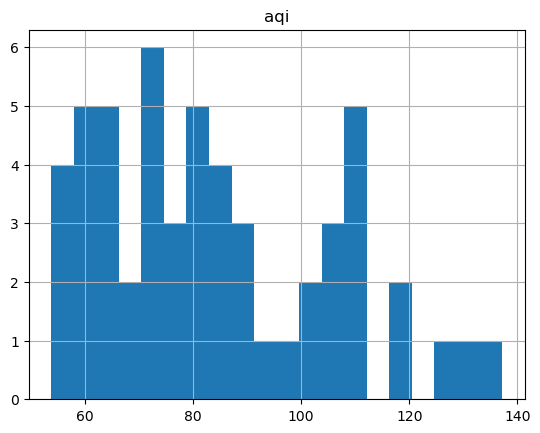

In [42]:
aqi_annual_estimate_df.hist(column=AQI_ESTIMATE_VALUE_COL, bins=20)

The AQI data doesn't seem to have any specific distribution shape, except a degree of right skew. 

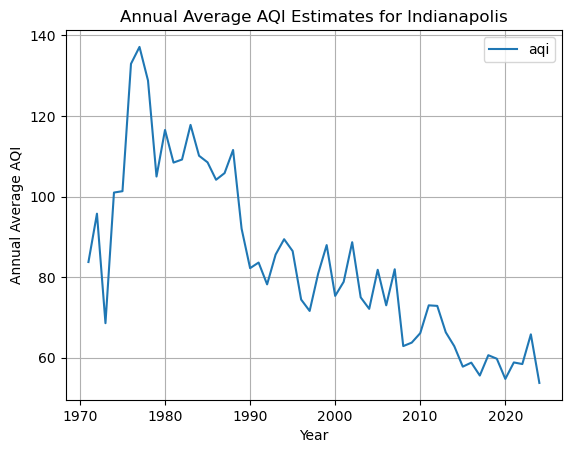

In [41]:
aqi_annual_estimate_df.plot(x=AQI_ESTIMATE_YEAR_COL, y=AQI_ESTIMATE_VALUE_COL)
plt.title('Annual Average AQI Estimates for Indianapolis')
plt.xlabel('Year')
plt.ylabel('Annual Average AQI')
plt.grid()
plt.show()  # Show the plot

Surprisingly, we see that the annual AQI values have gotten lower over time, in Indianapolis. 

Indeed, on further research of the state of Indiana as a whole (for a better overall picture), we see that there have been measures taken to improve the air quality in Indiana. For instance, the [2021 Fine Particles (PM2.5)](https://www.in.gov/idem/airmonitoring/files/monitoring_summary_pm_2021.pdf) Data Summary Report by IDEM shows a reduction in PM2.5 levels, which are tiny particles in the air that can pose health risks INDIANA.GOV. This decline is attributed to regulatory measures and efforts to reduce emissions from various sources.

However, it's important to note that while the overall trend has been positive, there have been instances where air quality has worsened in certain areas or during specific periods. For example, [a report](https://www.indianaenvironmentalreporter.org/federal-report-indicates-end-of-decades-long-air-quality-improvement/) from 2019 indicated that some Indiana counties experienced an increase in ozone levels between 2015 and 2018, suggesting that air quality improvements are not uniform across the state or across all pollutants